In [21]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
from matplotlib import lines as mlines
import matplotlib.pyplot as plt
from cycler import cycler

import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.CMS])

In [22]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

nfiles_mc = {}
nfiles_mc['2016'] = 113
nfiles_mc['2017'] = 167
nfiles_mc['2018'] = 201

nfiles_data = {}
nfiles_data['2016'] = 16
nfiles_data['2017'] = 19
nfiles_data['2018'] = 27

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [23]:
year = '2018'
outsum = processor.dict_accumulator()

In [24]:
# Load all MC
for n in range(1,nfiles_mc[year]+1):
    print(n)
    filename = 'condor/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates-revpt'].scale(scale_lumi, 'dataset')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


In [25]:
# Load all data
for n in range(1,nfiles_data[year]+1):
    print(n)
    filename = 'condor/outdata/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
# BE CAREFUL NOT TO UNBLIND
# Can you figure out how to blind it at this step???

1
File condor/outdata/2018_1.coffea is missing
2
3
File condor/outdata/2018_3.coffea is missing
4
5
6
7
8
9
10
11
12
13
14
15
16
File condor/outdata/2018_16.coffea is missing
17
18
19
20
21
22
23
24
25
26
27


In [26]:
templates = outsum['templates-revpt'].group('dataset', hist.Cat('process', 'Process'), pmap)

/uscms/home/jennetd/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:346: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fdc2a42e0b8>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [27]:
msd2_min = 75
msd2_max = 96
n2ddt2_cut = 0
pt2_cut = 550
templates = templates.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2_cut)).integrate('pt2',int_range=slice(pt2_cut,1200))

In [28]:
os.system('rm '+year+'/1-signalregion.root')
fout = uproot.create(year+'/1-signalregion.root')
for p in pmap.keys():  
    h = templates.integrate('region', 'signal').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
    fout[p+"_pass"] = hist.export1d(h)
    h = templates.integrate('region', 'signal').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
    fout[p+"_fail"] = hist.export1d(h)

fout.close()

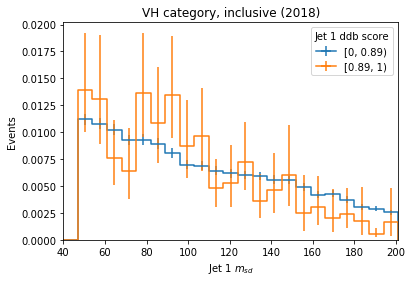

In [29]:
hist.plot1d(templates.integrate('region', 'signal').integrate('process','QCD'),overlay='ddb1',density=True)
plt.title('VH category, inclusive ('+year+')')
plt.savefig(year+'/plot-all/qcd-msd-all.png')

In [30]:
os.system('rm '+year+'/muonCR.root')
fout = uproot.create(year+'/muonCR.root')
for p in pmap.keys():  
    h = templates.integrate('region', 'muoncontrol').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
    fout[p+"_pass"] = hist.export1d(h)
    h = templates.integrate('region', 'muoncontrol').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
    fout[p+"_fail"] = hist.export1d(h)

fout.close()